In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [19]:
df = pd.read_csv('./AmazonSaleReport.csv')
df.columns

/var/folders/mw/2cx6x93d04g09y_zdvpb9vpc0000gn/T/ipykernel_74503/4289787963.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./AmazonSaleReport.csv')


Index(['Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

In [20]:

# transform date into datetime object
df['Date'] = pd.to_datetime(df['Date'])
df['Date_Y'] = df['Date'].dt.year
df['Date_M'] = df['Date'].dt.month
df['Date_D'] = df['Date'].dt.day
df = df.drop('Date', axis=1)

# A little bit of data cleaning
df.drop(['Order ID', 'Status', 'Unnamed: 22', 'SKU', 'ASIN', 'Courier Status', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'Style'], axis=1, inplace=True)

# Getting dummies and changing column names
# Fullfillment
df['fulfilled-by'] = df['fulfilled-by'].apply(lambda x: True if x == 'Easy Ship' else False)
df.rename(columns={'fulfilled-by': 'fulfilledEasyShip'}, inplace=True)

# Fullfillment again?
df['Fulfilment'] = df['Fulfilment'].apply(lambda x: True if x == 'Amazon' else False)
df.rename(columns={'Fulfilment': 'FBA'}, inplace=True)

# Sales channel
df['Sales Channel '] = df['Sales Channel '].apply(lambda x: True if x == 'Amazon.in' else False)
df.rename(columns={'Sales Channel ': 'soldAmazonIn'}, inplace=True)

# Currency
df['currency'] = df['currency'].apply(lambda x: True if x == 'INR' else False)
df.rename(columns={'currency': 'paidINR'}, inplace=True)

# Ship-Service-Level
df['ship-service-level'] = df['ship-service-level'].apply(lambda x: True if x == 'Standard' else False)
df.rename(columns={'ship-service-level': 'standardShipping'}, inplace=True)

# Check if it has promotions, convert to boolean
df['promotion-ids'] = df['promotion-ids'].apply(lambda x: False if pd.isna(x) else True)

# Size
df_dummies = pd.get_dummies(df, columns=['Size'])

# Categories
categories_to_delete = ['Ethnic Dress', 'Blouse', 'Bottom', 'Saree', 'Dupatta']
df_dummies = df_dummies[~df_dummies['Category'].isin(categories_to_delete)]
df_dummies = pd.get_dummies(df_dummies, columns=['Category'])

# Drop NaNs
df_dummies.dropna(inplace=True)

/var/folders/mw/2cx6x93d04g09y_zdvpb9vpc0000gn/T/ipykernel_74503/2963945487.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [21]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118628 entries, 0 to 128974
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   FBA                     118628 non-null  bool   
 1   soldAmazonIn            118628 non-null  bool   
 2   standardShipping        118628 non-null  bool   
 3   Qty                     118628 non-null  int64  
 4   paidINR                 118628 non-null  bool   
 5   Amount                  118628 non-null  float64
 6   promotion-ids           118628 non-null  bool   
 7   B2B                     118628 non-null  bool   
 8   fulfilledEasyShip       118628 non-null  bool   
 9   Date_Y                  118628 non-null  int32  
 10  Date_M                  118628 non-null  int32  
 11  Date_D                  118628 non-null  int32  
 12  Size_3XL                118628 non-null  bool   
 13  Size_4XL                118628 non-null  bool   
 14  Size_5XL                1

In [22]:
print(df_dummies.columns)

Index(['FBA', 'soldAmazonIn', 'standardShipping', 'Qty', 'paidINR', 'Amount',
       'promotion-ids', 'B2B', 'fulfilledEasyShip', 'Date_Y', 'Date_M',
       'Date_D', 'Size_3XL', 'Size_4XL', 'Size_5XL', 'Size_6XL', 'Size_Free',
       'Size_L', 'Size_M', 'Size_S', 'Size_XL', 'Size_XS', 'Size_XXL',
       'Category_Set', 'Category_Top', 'Category_Western Dress',
       'Category_kurta'],
      dtype='object')


In [23]:
# Splitting data into train and test
X = df_dummies.drop(['Amount', 'soldAmazonIn', 'paidINR'], axis=1)
y = df_dummies['Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Random Forest MSE: 42874.45017016116
Random Forest R^2: 0.45215844973545427


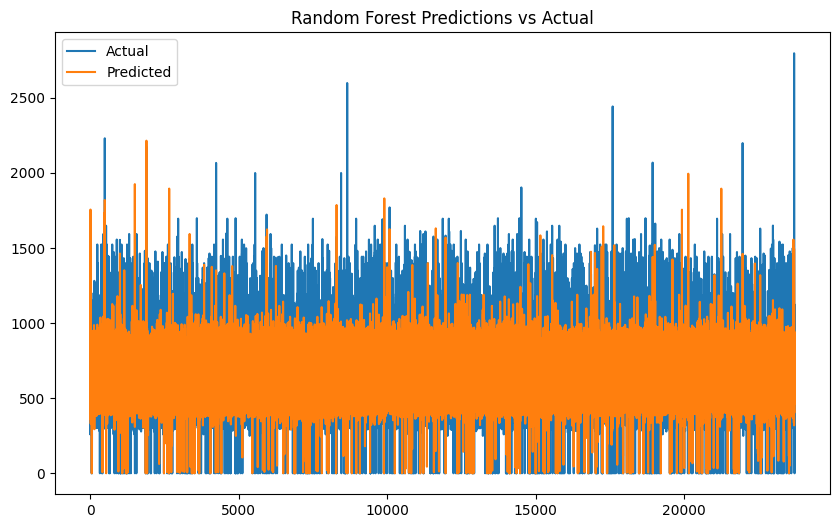

In [24]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize and train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest MSE: {mse_rf}')
r2_rf = rf.score(X_test, y_test)
print(f'Random Forest R^2: {r2_rf}')

# Plot the Random Forest results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='Predicted')
plt.title('Random Forest Predictions vs Actual')
plt.legend()
plt.show()

SVR MSE: 80205.37191367922
SVR R^2: -0.024848951166603905


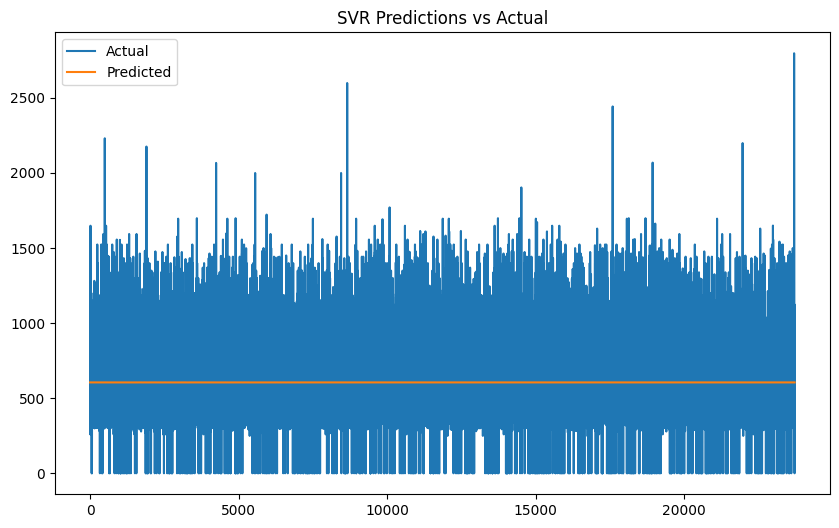

In [9]:
# SVR, no lo voy a correr porque me revienta el ordenador
from sklearn.svm import SVR

# Initialize and train the model
svr = SVR(kernel='rbf')  # Using Radial Basis Function (RBF) kernel
svr.fit(X_train, y_train)  # Fit the model to the training data

# Make predictions
y_pred_svr = svr.predict(X_test)  # Predict the target values for the test set

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)  # Calculate Mean Squared Error
r2_svr = svr.score(X_test, y_test)  # Calculate R^2 score
print(f'SVR MSE: {mse_svr}')
print(f'SVR R^2: {r2_svr}')

# Plot the SVR results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')  # Plot actual values
plt.plot(y_pred_svr, label='Predicted')  # Plot predicted values
plt.title('SVR Predictions vs Actual')
plt.legend()
plt.show()

Epoch 1/50


/Users/santi/Desktop/Proyecto/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2966/2966 ━━━━━━━━━━━━━━━━━━━━ 2s 425us/step - loss: 83101.7812
Epoch 2/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - loss: 72581.7500
Epoch 3/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - loss: 59200.9883
Epoch 4/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - loss: 50655.2969
Epoch 5/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - loss: 48241.2891
Epoch 6/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - loss: 48032.6914
Epoch 7/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - loss: 47678.5742
Epoch 8/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - loss: 48262.9258
Epoch 9/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - loss: 46742.6875
Epoch 10/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - loss: 46405.1484
Epoch 11/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - loss: 45658.6172
Epoch 12/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - loss: 47933.2461
Epoch 13/50
2966/2966 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - loss: 45594.8164
Epoch 14/50
2966/2966 ━━━━━━━━━━

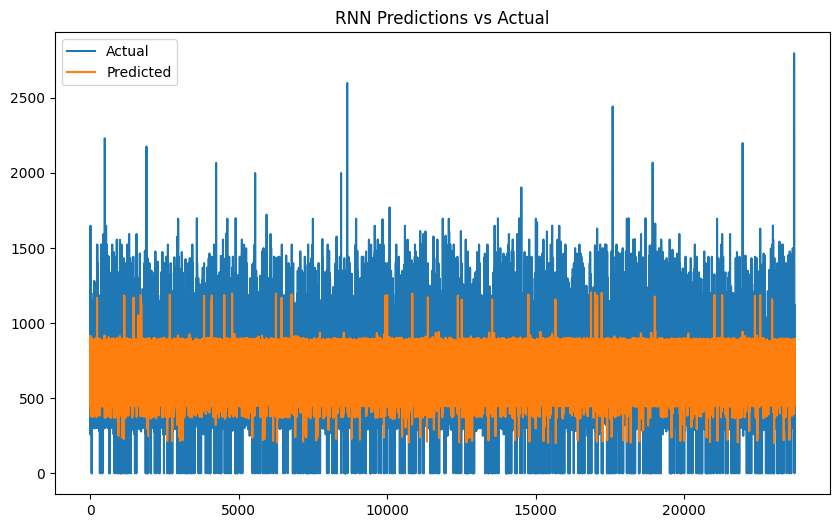

In [10]:
# RNN
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Reshape data for RNN
X_train_rnn = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Initialize and train the model
rnn = Sequential()
rnn.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train.shape[1])))
rnn.add(Dense(1))
rnn.compile(optimizer='adam', loss='mean_squared_error')

X_train_rnn = X_train_rnn.astype('float32')
y_train = y_train.astype('float32')
X_test_rnn = X_test_rnn.astype('float32')
y_test = y_test.astype('float32')
rnn.fit(X_train_rnn, y_train, epochs=50, batch_size=32)
# Make predictions
y_pred_rnn = rnn.predict(X_test_rnn)

# Evaluate the model
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
print(f'RNN MSE: {mse_rnn}')
r2_rnn = r2_score(y_test, y_pred_rnn)
print(f'RNN R^2: {r2_rnn}')

# Plot the RNN results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rnn, label='Predicted')
plt.title('RNN Predictions vs Actual')
plt.legend()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 94902, number of used features: 22
[LightGBM] [Info] Start training from score 649.822242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

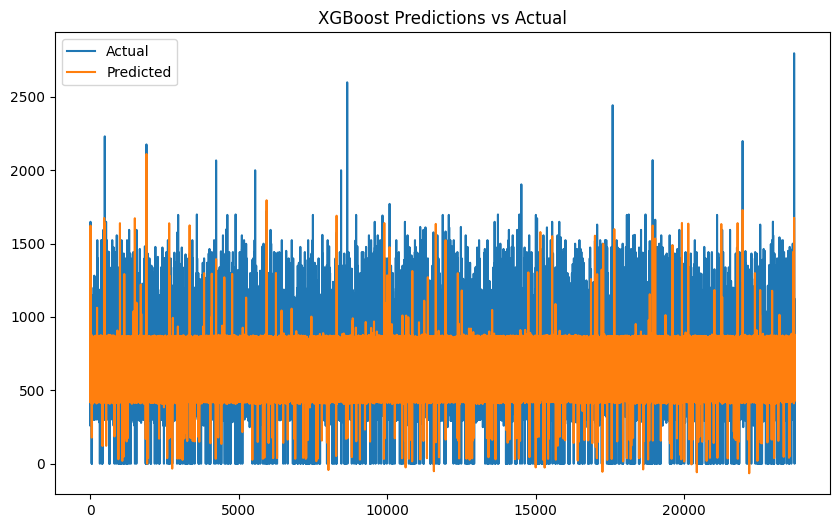

In [11]:
# XGBoost
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
lgb_reg = lgb.LGBMRegressor(objective='regression', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=100)
lgb_reg.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_reg.predict(X_test)

# Evaluate the model
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
print(f'LightGBM MSE: {mse_lgb}')
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f'LightGBM R^2: {r2_lgb}')

# Plot the XGBoost results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lgb, label='Predicted')
plt.title('XGBoost Predictions vs Actual')
plt.legend()
plt.show()

In [12]:
print(f'Random Forest MSE: {mse_rf}')
print(f'RNN MSE: {mse_rnn}')
print(f'SVR MSE: {mse_svr}')
print(f'XGBoost MSE: {mse_lgb}')

Random Forest MSE: 42868.16636587065
RNN MSE: 43765.39453125
SVR MSE: 80205.37191367922
XGBoost MSE: 40147.80969389456


In [14]:
print(f'Random Forest r2: {r2_rf}')
print(f'RNN r2: {r2_rnn}')
print(f'SVR r2: {r2_svr}')
print(f'XGBoost r2: {r2_lgb}')

Random Forest r2: 0.4522387429886716
RNN r2: 0.440774142742157
SVR r2: -0.024848951166603905
XGBoost r2: 0.4869989416149484


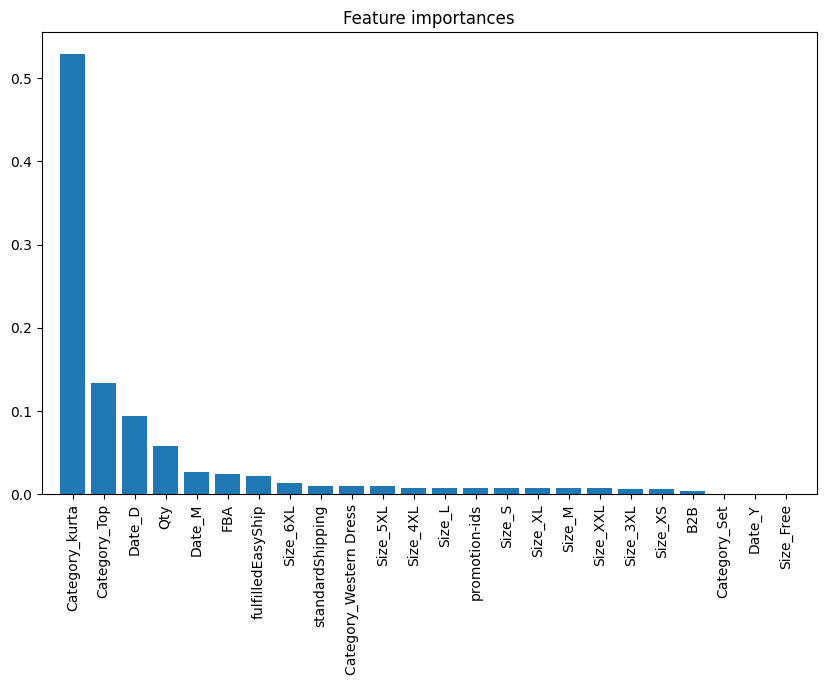

In [25]:


# Variable importance for Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()
